In [1]:
# imports
import sys, pathlib, glob
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# imports from the local code
repo_root_dir = pathlib.Path().resolve().parent

xrd_analysis_code_path = str(repo_root_dir / 'src' / 'xrd_analysis')
if xrd_analysis_code_path not in sys.path:
    sys.path.append(xrd_analysis_code_path)
from utils import get_raw_file_name
from analysis import get_peak_segments, get_segment_peak_fit
from plotting import plot_peak_segments, plot_segment_peak_fit

In [3]:
xrd_data_dir = repo_root_dir.parent / "xrd_example_files"

xrd_data_file_paths = glob.glob(f"{xrd_data_dir}/*.csv")

In [4]:
xrd_data_file = xrd_data_file_paths[0]

In [5]:
print(get_raw_file_name(xrd_data_file))

ML_Wallace_17122019_1_NN_1_ZrP_Crucible_12x16_14x161of2Crucibles_BlackPowder_5-60_4min_BkgSubtracted.raw



In [6]:
xrd_df = pd.read_csv(xrd_data_file, skiprows=2, names=["angle", "counts"])

In [7]:
peak_segments = get_peak_segments(xrd_df)

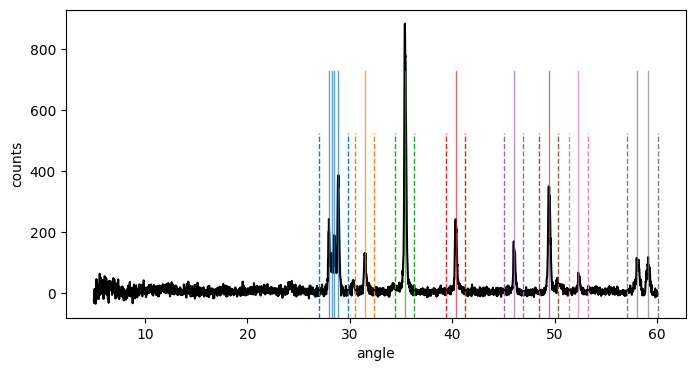

In [8]:
plot_peak_segments(xrd_df, peak_segments)

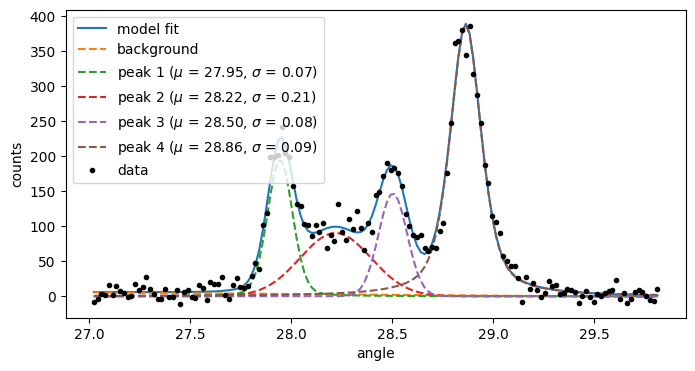

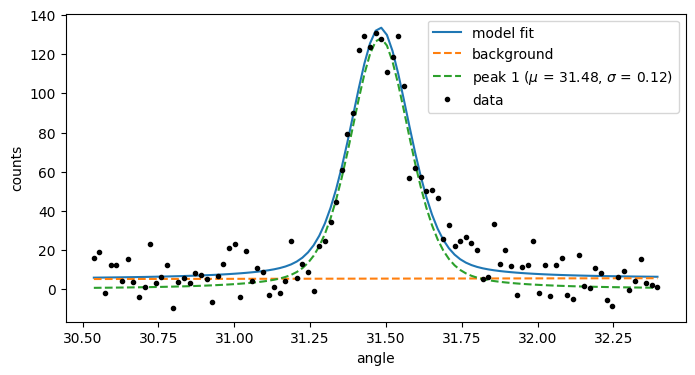

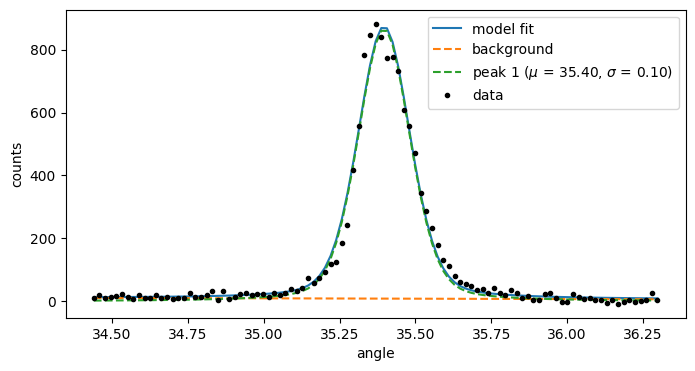

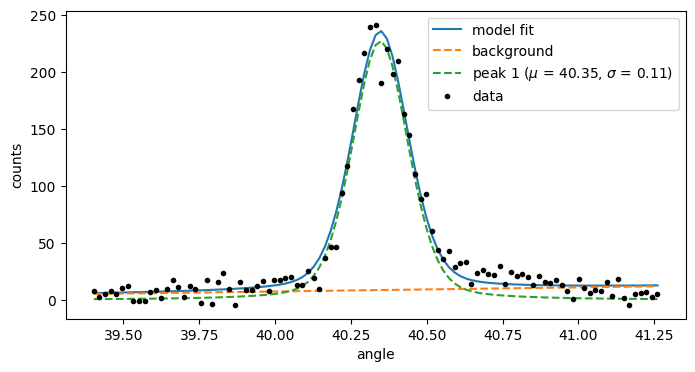

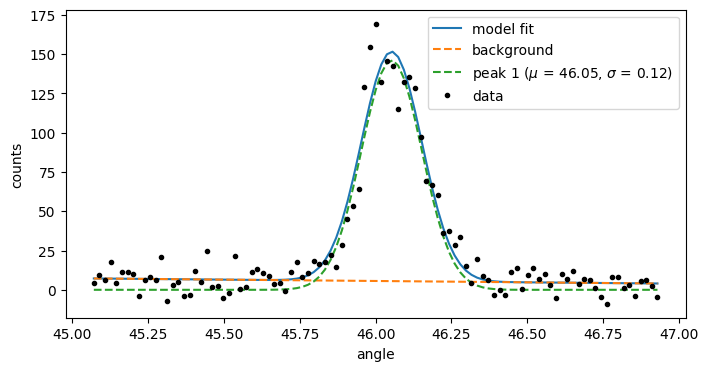

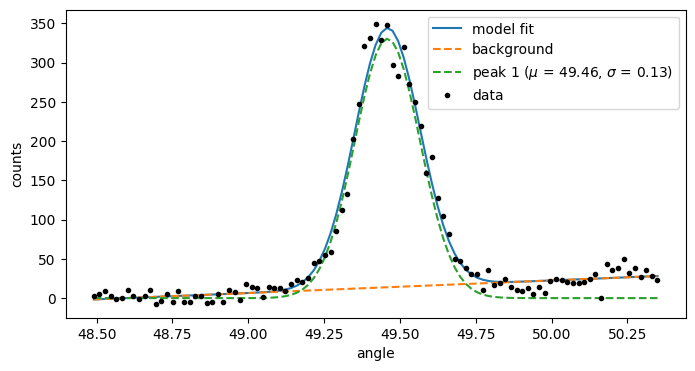

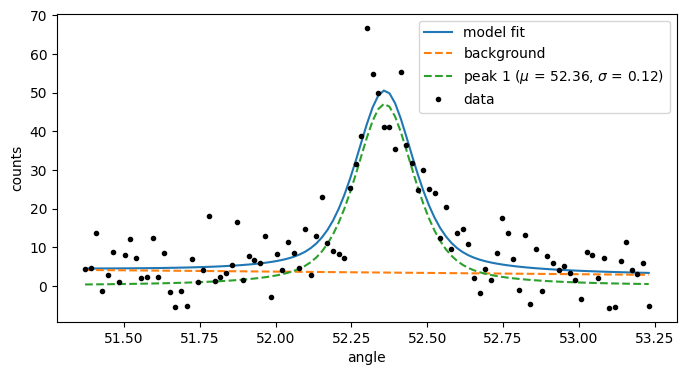

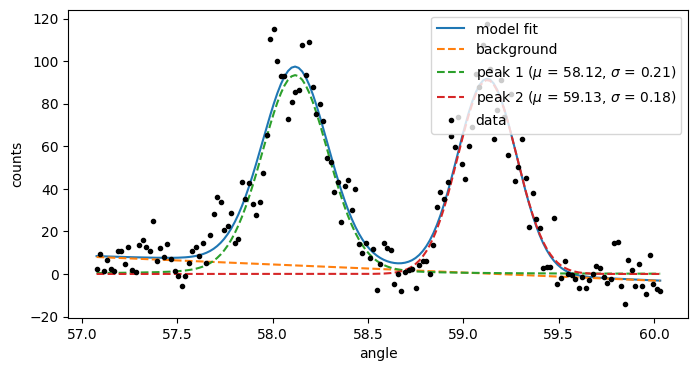

In [9]:
for peak_seg in peak_segments:
    # Pull out the part of the dataframe that's within the segment
    seg_df = xrd_df[
        ((xrd_df["angle"] >= peak_seg["min"]) & (xrd_df["angle"] <= peak_seg["max"]))
    ]
    fit_result = get_segment_peak_fit(xrd_df,peak_seg)
    plot_segment_peak_fit(seg_df,fit_result)